<div class="alert alert-block alert-info">
    <h1>Natural Language Processing</h1>
    <h3>General Information:</h3>
    <p>Please do not add or delete any cells. Answers belong into the corresponding cells (below the question). If a function is given (either as a signature or a full function), you should not change the name, arguments or return value of the function.<br><br> If you encounter empty cells underneath the answer that can not be edited, please ignore them, they are for testing purposes.<br><br>When editing an assignment there can be the case that there are variables in the kernel. To make sure your assignment works, please restart the kernel and run all cells before submitting (e.g. via <i>Kernel -> Restart & Run All</i>).</p>
    <p>Code cells where you are supposed to give your answer often include the line  ```raise NotImplementedError```. This makes it easier to automatically grade answers. If you edit the cell please outcomment or delete this line.</p>
    <h3>Submission:</h3>
    <p>Please submit your notebook via the web interface (in the main view -> Assignments -> Submit). The assignments are due on <b>Wednesday at 15:00</b>.</p>
    <h3>Group Work:</h3>
    <p>You are allowed to work in groups of up to two people. Please enter the UID (your username here) of each member of the group into the next cell. We apply plagiarism checking, so do not submit solutions from other people except your team members. If an assignment has a copied solution, the task will be graded with 0 points for all people with the same solution.</p>
    <h3>Questions about the Assignment:</h3>
    <p>If you have questions about the assignment please post them in the LEA forum before the deadline. Don't wait until the last day to post questions.</p>
    
</div>


# Yelp Classifier

You are given a set of $1,600$ Yelp reviews. Of these $800$ are rated with $5$ stars and the remaining $800$ with $1$ star.

We now want to train a classifier using a LSTM to determine if a review is positive ($5$ stars) or negative ($1$ star). Each review is a dictionary with the fields ```text``` and ```stars```. The field ```text``` contains the tokenized review, the field ```stars``` contains the rating.

In [22]:
import pickle
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import (Input, Dense, Activation, Embedding, LSTM)
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split

# Setting a random seed for better reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [23]:
with open('/srv/shares/NLP/yelp_binary.pkl', 'rb') as f:
    reviews = pickle.loads(f.read())
    
# Show a sample review
print(reviews[3])

{'text': ['10', 'pm', 'on', 'a', 'super', 'bowl', 'Sunday', 'and', 'they', "'re", 'already', 'closed', '?', '?', 'Weak', ',', 'no', 'wonder', 'the', 'hard', 'Rock', 'is', 'dying', 'off', '...'], 'stars': 1}


## Yelp Classifier A) [5 points]

### Preparing the data

Take the reviews and create the following two lists / arrays:

- ```X```: Contains the tokenized reviews (list of lists of strings)
- ```Y```: Contains the rating of the review (use $0$ for reviews with $1$ star and 1 for reviews with $5$ stars)

Next we split the data into a train and a test set using the function ```train_test_split``` from ```sklearn```. We use a test_size of $0.15$ ($15\%$) and store these in the variables ```X_train```, ```Y_train```, ```X_test```, ```Y_test```. We also set the random state to our seed (see imports cell) for reproducibility.

In [24]:
X = [[]]         # This should be a list of lists of strings
Y = np.array([]) # This should be a numpy array

# YOUR CODE HERE

X = [review['text'] for review in reviews]
Y = np.array([0 if review['stars'] == 1 else 1 for review in reviews])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=seed)

print(len(X_train))  # Should be 1360
print(len(X_test))   # Should be  240
print(Y_train.shape) # Should print (1360,)
print(Y_test.shape)  # Should print (240,)

1360
240
(1360,)
(240,)


In [25]:
# This is a test cell. Please ignore it!

## Yelp Classifier B) [5 points]

### Tokenize reviews into integer indexes

Next we need to tokenize the reviews into integer indexes. For this we can use the build in tokenizer from keras (```tensorflow.keras.preprocessing.text.Tokenizer```). We only want to take the $5000$ most frequent words for this, ignoring all others.

The tokenizer has the following methods we will use:

- ```__init__(self, num_words)```: Constructor that takes the number of most frequent words we want to keep
- ```fit_on_texts(self, data)```: Fit the tokenizer on the data (e.g. our train inputs)
- ```texts_to_sequences(self, texts)```: Convert a list of texts or list of tokenized reviews to a list of integer indexes
- ```sequences_to_texts(self, sequences)```: Convert a list of sequences back to texts

**Attention:** We only want to fit our tokenizer on the train reviews, not on the test reviews.

Your task is now to:

1. Create a tokenizer that only keeps the $5000$ most frequent words
2. Fit the tokenizer on our training data
3. Convert the training data (```X_train```) to integer sequences and store these in the variable ```train_sequences```.
4. Convert the test data (```X_test```) to integer sequences and store these in the variable ```test_sequences```.

In [26]:
tokenizer = None

#training_sequences = [[]]
train_sequences =[[]]
test_sequences = [[]]

# YOUR CODE HERE
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# To make sure everything worked print a training example (this should print a list of integers)
print(train_sequences[3])
print()

# Next take this list of integers and convert it back to a text
print(tokenizer.sequences_to_texts([train_sequences[3]]))
print()

# Compare this to the corresponding training review
print(X_train[3])
print()

[71, 132, 9, 118, 2641, 1007, 9, 61, 15, 139, 393, 5, 3, 159, 1, 61, 1267, 148, 1818, 3, 781, 9, 2642, 61, 34, 25, 38, 37, 139, 7, 152, 2641, 1007, 3905, 2, 6, 394, 42, 9]

["great experience ! love amanda r ! she is always sweet , and friendly . she goes way above and beyond ! mornings she 's not there are always a little amanda r adds the to working out !"]

['Great', 'experience', '!', 'Love', 'Amanda', 'R', '!', 'She', 'is', 'always', 'sweet', ',', 'energetic', 'and', 'friendly', '.', 'She', 'goes', 'way', 'above', 'and', 'beyond', '!', 'Mornings', 'she', "'s", 'not', 'there', 'are', 'always', 'a', 'little', 'duller-', 'Amanda', 'R', 'adds', 'the', 'sparkle', 'to', 'working', 'out', '!']



In [27]:
# This is a test cell. Please ignore it!

## Yelp Classifier C) [15 points]

### Converting the sequences to sequences of equal length

Since the reviews vary in length, the training sequences will have different lengths.

We want to make sure all training sequences have the same length. The length of our sequences is a hyperparameter. 

#### 1) Determining a maximum sequence length [10 points]

To determine a good value for the maximum sequence length we can plot a histogram of sequence lengths, together with some statistical parameters (mean, median, $90\%$ quantile).

Here we can pick the $90\%$ quantile (you can use ```numpy.quantile``` for this).

Please plot the histrogram of the train sequence lengths. Add the mean, median and $90\%$ quantile as vertical lines.

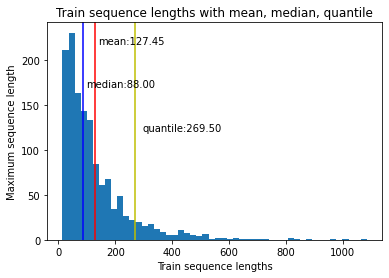

In [37]:
# Answer
sequence_lengths = []
for i in range(len(train_sequences)):
    sequence_lengths.append(len(train_sequences[i]))
#print(sequence_lengths)
sequence_mean = np.mean(sequence_lengths)
sequence_median = np.median(sequence_lengths)
sequence_quantile = np.quantile(sequence_lengths,0.9)

plt.hist(sequence_lengths,bins=50)
plt.axvline(sequence_mean,color="r")
plt.axvline(sequence_median,color = "b")
plt.axvline(sequence_quantile,color = "y")

min_ylim,max_ylim = plt.ylim()
plt.text(sequence_mean*1.1,max_ylim*0.9,"mean:{:.2f}".format(sequence_mean))
plt.text(sequence_median*1.1,max_ylim*0.7,"median:{:.2f}".format(sequence_median))
plt.text(sequence_quantile*1.1,max_ylim*0.5,"quantile:{:.2f}".format(sequence_quantile))

plt.xlabel("Train sequence lengths")
plt.ylabel("Maximum sequence length")
plt.title("Train sequence lengths with mean, median, quantile")
plt.show()

# The 90% quantile should be around 270 

#### 2) Padding / truncating the sequences [5 points]

We found out that $90\%$ of the reviews have a length of $\leq 270$. 

Pad the training and test sequences using the function ```tensorflow.keras.preprocessing.sequence.pad_sequences```.

Store these in the variables:

- ```padded_train_sequences```
- ```padded_test_sequences```

In [29]:
padded_train_sequences = np.array([[]])
padded_test_sequences = np.array([[]])
# YOUR CODE HERE
padded_train_sequences = pad_sequences(train_sequences,maxlen=270)
padded_test_sequences = pad_sequences(test_sequences,maxlen=270)

print(padded_train_sequences.shape) # Should print (1360, 270)
print(padded_test_sequences.shape)  # Should print  (240, 270)

(1360, 270)
(240, 270)


In [30]:
# This is a test cell. Please ignore it!

## Yelp Classifier D)

### Define our model

Our model should consist of the following layers:

- Embedding layer with output dimension $32$
- LSTM layer with output dimension $8$
- Fully connected layer with a single output and sigmoid activation function

Store your model in the variable ```yelp_model``` and print a summary.

Your summary should look similar to this:

```
Model: "Yelp_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, 270)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 270, 16)           80016     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
=================================================================
Total params: 80,825
Trainable params: 80,825
Non-trainable params: 0
```

In [31]:
yelp_model = None
# YOUR CODE HERE

input_object = Input(shape=(270,))

# Embedding layer
embedding_layer = Embedding(input_dim = np.max(padded_train_sequences)+1,output_dim = 32)
y_embedding = embedding_layer(input_object)

# LSTM layer
lstm_layer = LSTM(8)
y_lstm = lstm_layer(y_embedding)

# Create another dense NN layer with a single output
output_layer = Dense(1, activation='sigmoid')
# Apply the output of the embedding and LSTM layer to this layer
y = output_layer(y_lstm)

# Piece everything together into a model
yelp_model = Model(input_object, y, name='yelp_model')

# Summarize the model
yelp_model.summary()

Model: "yelp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 270)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 270, 32)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 161,321
Trainable params: 161,321
Non-trainable params: 0
_________________________________________________________________


## Yelp Classifier E)

### Compile our model

Finally we need to compile our model.

Use the binary crossentropy loss, the optimizer Adam and accuracy as a metric.

Next fit the model to our training data using a batch size of $32$ for a total of $10$ epochs.

**Attention:** Each time you execute this cell the model will be trained more (e.g. execute it once and we train for $10$ epochs, execute it twice and we train for $20$ epochs, ...). To reset the model execute the cell above again.

In [32]:
# Answer

# Please write your code answer here!
# Compile the model
yelp_model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = 'adam',
    metrics = ['accuracy'] )

# Train the model on the inputs
history = yelp_model.fit(
    x = padded_train_sequences,
    y = Y_train,
    epochs = 10,
    batch_size = 32,
    verbose = 0)

# Test the model after training
test_results = yelp_model.evaluate(padded_test_sequences, Y_test, verbose=False)

print()
print(f'Test results - Loss: {test_results[0]:.4f} - Accuracy: {100*test_results[1]:.2f}%')


Test results - Loss: 0.2702 - Accuracy: 90.42%


## Yelp Classifier E) [15 points]

### Bonus Task - Extract the embeddings

This is a bonus task. You do not need to solve it to get $100\%$ on this assignment.

Extract the embeddings from the embedding layer of your model and create a dictionary for the embeddings.

The embeddings are stored in the weight matrix of the embedding layer (```get_weights()```).

To find out which row of the embedding matrix corresponds to which word we need to use the word_index of our tokenizer. This is a dictionary containts the words (tokens) as keys and their index as a value. We only look at the first $5000$ entries of the word index.

Next create a VectorModel (see Assignment 4) with these embeddings and print the most similar words to the following input words:

```['good', 'bad', 'fantastic', 'poor', 'amazing']```

In [33]:
# Answer

# Please write your code answer here!

'''
embeddings_index = dict()
embedding_matrix = np.zeros((5000, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
'''
    # YOUR CODE HERE
#raise NotImplementedError()

'\nembeddings_index = dict()\nembedding_matrix = np.zeros((5000, 100))\nfor word, i in tokenizer.word_index.items():\n    embedding_vector = embeddings_index.get(word)\n    if embedding_vector is not None:\n        embedding_matrix[i] = embedding_vector\n        \n'


# Sequence to Sequence

We want to train a sequence to sequence model, consisting of an LSTM encoder and an LSTM decoder.

For this we use a dummy task that consists of translating date strings from one format to another.


In [34]:
import numpy as np
import random as rd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Embedding, Dense, LSTM, 
                                     TimeDistributed, Input, RepeatVector, Activation)
from tensorflow.keras.losses import sparse_categorical_crossentropy

from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split

In [35]:

def translate_date(day, month, year):
    return (
        f'{day:02}-{month:02}-{year}',
        f'{year:04}-{month:02}-{day:02}'
    )

def create_sample():
    year = rd.choice(years)
    day = rd.choice(days)
    month = rd.choice(months)
    return translate_date(day, month, year)

def create_samples(n_samples=5000):
    samples = set()
    while len(samples) < n_samples:
        samples.add(create_sample())
    return list(samples)

years = range(1000, 2022)
days = range(1, 29)
months = range(1, 13)

N_samples = 10000

samples = create_samples(N_samples)

# Split into X and Y
X, Y = zip(*samples)
X = [list(x) for x in X]
Y = [list(y) for y in Y]

# Train / Test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# Print the first three inputs and first three outputs
print(X_train[:3])
print(Y_train[:3])

[['1', '6', '-', '0', '7', '-', '1', '3', '2', '6'], ['2', '8', '-', '0', '6', '-', '1', '6', '9', '4'], ['1', '3', '-', '1', '2', '-', '1', '7', '9', '2']]
[['1', '3', '2', '6', '-', '0', '7', '-', '1', '6'], ['1', '6', '9', '4', '-', '0', '6', '-', '2', '8'], ['1', '7', '9', '2', '-', '1', '2', '-', '1', '3']]


## Sequence to Sequence A) [5 points]

### Tokenize the data using keras built-in tokenizer.

Since our outputs are also sequences, we need to fit our tokenizer on the combined input and output (```X_train + Y_train```).

Finally create the four variables ```X_train_sequences```, ```Y_train_sequences```, ```X_test_sequences``` and ```Y_test_sequences``` from your train and test data.

Since all inputs and outputs have the same lenght, we do not need to apply any padding / truncating of the sequences.

In [16]:
tokenizer = None

# YOUR CODE HERE
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(X_train+Y_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
Y_train_sequences = tokenizer.texts_to_sequences(Y_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
Y_test_sequences = tokenizer.texts_to_sequences(Y_test)
# Make sure we are working with numpy arrays:

X_train_sequences = np.array(X_train_sequences)
Y_train_sequences = np.array(Y_train_sequences)
X_test_sequences = np.array(X_test_sequences)
Y_test_sequences = np.array(Y_test_sequences)

print(X_train_sequences.shape) # Should print (4250, 10)
print(Y_train_sequences.shape) # Should print (4250, 10)

print(X_test_sequences.shape)  # Should print (750, 10)
print(Y_test_sequences.shape)  # Should print (750, 10)

print(tokenizer.word_index)

(8500, 10)
(8500, 10)
(1500, 10)
(1500, 10)
{'1': 1, '-': 2, '0': 3, '2': 4, '4': 5, '6': 6, '3': 7, '8': 8, '5': 9, '7': 10, '9': 11}


In [17]:
# This is a test cell. Please ignore it!

## Sequence to Sequence B) [25 points]

### Define your model

Create a model consisting of:

- An embedding layer with output dimensionality of $64$
- A LSTM layer (Encoder) with outputs of size $32$
- A LSTM layer (Decoder) with outputs of size $32$
- A dense layer
- An activation layer using the softmax

**Attention:** You will need the ```RepeatVector``` and ```TimeDistributed``` objects.

- ```RepeatVector``` takes a vector as an input and repeats it $n$ times. This is useful to repeat the output of the encoder such that the decoder is fed the last output of encoder at each time step.
- ```TimeDistributed``` is a wrapper around a layer (e.g. a dense layer) that takes a sequence of inputs and creates a sequence of outputs by applying the layer to each element of the input sequence.

Your model summary should look similar to this:

```
Model: "Seq2Seq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 10, 64)            768       
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 32)            8320      
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 12)            396       
_________________________________________________________________
activation (Activation)      (None, 10, 12)            0         
=================================================================
Total params: 21,900
Trainable params: 21,900
Non-trainable params: 0
_________________________________________________________________
```

In [18]:
# Answer

# Please write your code answer here!

# Define an input sequence and process it.
inputs = Input(shape=(10, ))

# An embedding layer with output dimensionality of  64
embedding = Embedding(input_dim = np.max(X_train_sequences)+1, output_dim = 64)
y_embedding = embedding(inputs)

# A LSTM layer (Encoder) with outputs of size  32
encoder_lstm = LSTM(32)
encoder_outputs = encoder_lstm(y_embedding)

# Repeat vector
repeat_vector = RepeatVector(10)(encoder_outputs)

# A LSTM layer (Decoder) with outputs of size  32
decoder_lstm = LSTM(32, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(repeat_vector)

# A dense layer with TimeDistributed object
dense = TimeDistributed(Dense(12, activation='softmax'))
decoder_outputs = dense(decoder_outputs)

# An activation layer using the softmax
activation = Activation('softmax')
decoder_outputs = activation(decoder_outputs)

seq2seq_model = Model(inputs, decoder_outputs, name='seq2seq_model')
seq2seq_model.summary()

Model: "seq2seq_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 64)            768       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                [(None, 10, 32), (None, 3 8320      
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 12)            396       
_________________________________________________________________
activation (Activation)      (None, 10, 12)          

## Sequence to Sequence C) [5 points]

### Compile your model

Compile your model using adam as an optimizer, accuracy as a metric and sparse_categorical_crossentropy as your loss.

Then fit your model on the training data using $20$ epochs and a batch size of $32$.

In [19]:
# YOUR CODE HERE
seq2seq_model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

# Train the model on the inputs
history = seq2seq_model.fit(x = X_train_sequences,
                            y = Y_train_sequences,
                            epochs = 20,
                            batch_size = 32,
                            verbose=0)

# Test the model after training
test_results = seq2seq_model.evaluate(X_test_sequences, Y_test_sequences, verbose=False)
print()
print(f'Test results - Loss: {test_results[0]:.4f} - Accuracy: {100*test_results[1]:.2f}%')


Test results - Loss: 1.9345 - Accuracy: 69.59%


## Sequence to Sequence D) [10 points]
 
### Use your model for inference

We now want to use the model to convert a single date (```20-05-1973```).

This process consists of the following steps:

1. Convert the date to a sequence.
2. Predict the output of the model for that sequence
3. Print the predicted date

The prediction will be a sequence of vectors, where each element in the vector corresponds to the probability of that vector representing the token with that index. 

Example:

The output of your model would be the ten vectors $[v_0, v_1, v_2, ..., v_9]$. Now each vector has 12 elements:

$v_i = [a_0, a_1, ... ,a_{10}, a_{11}]$, $\quad\sum_{i=0}^{11} a_i = 1$. (Because of applying the softmax)

The element $a_1$ is the probability that the predicted token is the one with index $1$. 

To convert each of the vectors $v_i$ to an integer index we need to find the index of the largest $a_i$ of that vector (argmax).

Then we get an output sequence like $[1, 4, 2, 5, 3, 7, 6, 3, 2, 4]$. This sequence can now be converted back to a text using the method ```sequences_to_texts``` of the tokenizer.

In [20]:
# Answer

# Please write your code answer here!
date = "20-05-1973"

date_tokens = [[x for x in date]]
sequence = tokenizer.texts_to_sequences(date_tokens)
print(sequence)

output = seq2seq_model.predict(sequence)

pred_seq = []
for i in range(0,10):
    pred_seq.append(np.argmax(output[0][i]))
prediction_sequence = [pred_seq]
print(prediction_sequence)

prediction = tokenizer.sequences_to_texts(prediction_sequence)
print(prediction)
#raise NotImplementedError()

[[4, 3, 2, 3, 9, 2, 1, 11, 10, 7]]
[[1, 11, 9, 9, 2, 3, 4, 2, 3, 3]]
['1 9 5 5 - 0 2 - 0 0']
